# Dedect Water Flow using MFCC 
Instead of looking for tempo clusters, this notebook looks for mfcc values. This comes from the idea that we have various features like pitches, timbre and tempo. We can use these features to detect water flow. Most of the code in this notebook is done with chatGPT, and also debugged with chatGPT.

## Import the necessary libraries

In [3]:
import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline




## Step 2: Prepare the Audio Data
The recordings come from three differen phonnes and recorded in different environments. 
1. To make this more comparable, we need to normalize the audio data.
2. We chop of silence at the beginning and end

In [4]:
# Function to trim silence from the beginning and end of an audio signal
def trim_silence(y, sr, top_db=20):
    """Trim silence from the beginning and end of an audio signal."""
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed

def normalize_loudness(y):
    """Normalize audio to have consistent loudness."""
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y / rms
    return y

def load_and_preprocess_audio(file_path, target_sr=16000):
    """Load and preprocess audio file."""
    y, sr = librosa.load(file_path, sr=None)
    
    # Step 1: Trim silence
    y = trim_silence(y, sr)
    
    # Step 2: Downsample if necessary
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    
    # Step 3: Normalize loudness
    y = normalize_loudness(y)
    return y


## 2.2: Load Audio Files
We have a dataset folders with all the audio files. We can load them with the `load_audio_files` function, and process them with the `process_audio_files` function.

In [5]:
# Path to your dataset folder
dataset_path = '../dataset'

# Get list of audio files
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio data
audio_data = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    audio_data.append(y)


Loading and preprocessing audio files:   0%|          | 0/615 [00:00<?, ?it/s]

## Step 3: Extract Features for RNN Input

### 3.1: Define Feature Extraction Function
40 Features are chosen. This is the common size of features. 

In [6]:
def extract_mfcc_features(y, sr=16000, n_mfcc=40):
    """Extract MFCC features from audio signal."""
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # Shape: (Time steps, n_mfcc)
    return mfcc


### 3.2: Extract Features from All Audio Data
This process converts a batch of raw audio signals into their corresponding MFCC feature sets, which can be further used for machine learning tasks like classification, clustering, or other types of audio analysis. It transforms the data from raw waveforms into a more compact, structured format that highlights the most important audio features.

In [7]:
# List to hold feature sequences
feature_sequences = []

for y in tqdm(audio_data, desc='Extracting features'):
    features = extract_mfcc_features(y)
    feature_sequences.append(features)


Extracting features:   0%|          | 0/615 [00:00<?, ?it/s]

## Step 4: Prepare Data for PyTorch

### 4.1: Create a Custom Dataset
1. Create new AudioDataset from Dataset
2. All the important informations are loaded into the dataset

In [8]:
class AudioDataset(Dataset):
    def __init__(self, feature_sequences):
        self.feature_sequences = feature_sequences

    def __len__(self):
        return len(self.feature_sequences)

    def __getitem__(self, idx):
        return self.feature_sequences[idx]


## 4.2: Define a Collate Function to Handle Variable Sequence Lengths
The audiofiles are cut into peaces of about 3 Sek. and put into an array of batch_data 
 

In [9]:
def collate_fn_fixed_length(batch):
    # Load precomputed mean and std
    data_mean = np.load('data_mean.npy')
    data_std = np.load('data_std.npy')

    # Pad sequences to fixed length and normalize
    fixed_length = 100  # Adjust as needed
    batch_data = []
    for sequence in batch:
        if len(sequence) < fixed_length:
            # Pad with zeros
            pad_length = fixed_length - len(sequence)
            padded_sequence = np.pad(sequence, ((0, pad_length), (0, 0)), 'constant')
        else:
            # Truncate sequence
            padded_sequence = sequence[:fixed_length, :]
        # Normalize using global mean and std
        normalized_sequence = (padded_sequence - data_mean) / data_std
        batch_data.append(normalized_sequence)
    batch_data = np.stack(batch_data)
    return torch.tensor(batch_data)


## 4.x Normalize Input Data Using Training Data Statistics
The Train Data is put together into a 2D Array

In [10]:
# Concatenate all training data to compute mean and std
all_train_data = np.concatenate(feature_sequences, axis=0)  # feature_sequences is a list of numpy arrays

# Compute mean and std over the entire training data
data_mean = np.mean(all_train_data, axis=0)
data_std = np.std(all_train_data, axis=0)

# Save mean and std for later use
np.save('data_mean.npy', data_mean)
np.save('data_std.npy', data_std)



## 4.3: Create DataLoader (New with Trainingset)
Split Data into training and validation set

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets (e.g., 80% training, 20% validation)
train_data, val_data = train_test_split(feature_sequences, test_size=0.2, random_state=42)

# Create DataLoaders for training and validation sets
train_dataset = AudioDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_fixed_length)

val_dataset = AudioDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_fixed_length)


## Step 5: Define the RNN Autoencoder Model
### 5.1: Define the Model
1. Input Size comes from Features and is in the next cell defined. 
2. The use of GRUs makes this model capable of capturing temporal patterns in the data, and dropout helps to ensure that the model generalizes well to new data.

In [12]:
class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNAutoencoder, self).__init__()
        self.hidden_size = hidden_size

        # Encoder
        self.encoder_rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout_enc = nn.Dropout(p=0.5)  # Increased dropout rate for encoder

        # Decoder
        self.decoder_rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout_dec = nn.Dropout(p=0.5)  # Dropout for decoder

        # Output layer
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # Encoder
        _, hidden = self.encoder_rnn(x)
        hidden = self.dropout_enc(hidden)  # Apply dropout to encoder hidden state

        # Decoder input: zeros
        batch_size, seq_len, _ = x.size()
        decoder_input = torch.zeros(batch_size, seq_len, self.hidden_size).to(x.device)

        # Decoder hidden state
        decoder_hidden = hidden

        # Decoder
        outputs, _ = self.decoder_rnn(decoder_input, decoder_hidden)
        outputs = self.dropout_dec(outputs)  # Apply dropout to decoder outputs

        # Output layer
        outputs = self.output_layer(outputs)

        return outputs


5.2: Initialize the Model

In [13]:
input_size = feature_sequences[0].shape[1]  # n_mfcc
hidden_size = 120  # Reduced hidden size to prevent overfitting

model = RNNAutoencoder(input_size, hidden_size)


### Step 6: Define Loss Function and Optimizer
1. The Mean Squared Error loss function is used to quantify how closely the model’s reconstructed output matches the original input. It measures the average of the squared differences between the predicted and actual values.
2. The Adam optimizer is responsible for updating the model’s weights based on the gradients calculated from the loss. It uses a learning rate of 0.001 and applies L2 regularization (weight decay) to prevent overfitting.

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


## !!!!! OPTIONAL !!!! 


Resume Training form a previously saved model. (This means you need to run step 7 at least one time before)




In [121]:
import os
import torch

# Load the model and optimizer if resuming training
model = RNNAutoencoder(input_size, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the checkpoint directory
checkpoint_dir = 'checkpoints_02'

# Path to the best model checkpoint
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

# Load the checkpoint (e.g., from the best model or specific epoch)
checkpoint = torch.load(best_model_path)

# Check if the checkpoint is a state dict or a full checkpoint with additional info
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    # The checkpoint contains additional information
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model state loaded successfully from checkpoint.")
    
    # Load the optimizer state dict
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0)  # Use 0 if 'epoch' is not found
        print(f"Optimizer state and epoch {start_epoch} loaded successfully.")
    else:
        print("Optimizer state not found in checkpoint. Starting from scratch.")
        start_epoch = 0
else:
    # The checkpoint is only the model state dict
    model.load_state_dict(checkpoint)
    print("Model state loaded successfully from state dict.")
    print("Optimizer state not found in checkpoint. Starting optimizer from scratch.")
    start_epoch = 0

print(f"Resuming training from epoch {start_epoch}")


Model state loaded successfully from state dict.
Optimizer state not found in checkpoint. Starting optimizer from scratch.
Resuming training from epoch 0


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_70060/1180924958.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


## Step 7: Train the Model
This code is a robust training and validation loop for PyTorch models. It incorporates:

1. GPU support, dynamic learning, regularization, and efficient training.
2. Early stopping to prevent overfitting.
3. Checkpoint saving to manage models efficiently and recover the best-performing model.
4. Visualization to track and evaluate training progress.

Epoch 1/1000: 100%|██████████| 31/31 [00:01<00:00, 24.31it/s]


Epoch [1/1000], Train Loss: 0.9722, Val Loss: 0.9781
Full checkpoint saved for epoch 1
Removed old checkpoint: checkpoint_epoch_1.pth
Best model saved with validation loss: 0.9781


Epoch 2/1000: 100%|██████████| 31/31 [00:01<00:00, 24.77it/s]


Epoch [2/1000], Train Loss: 0.9635, Val Loss: 0.9738
Full checkpoint saved for epoch 2
Removed old checkpoint: checkpoint_epoch_2.pth
Best model saved with validation loss: 0.9738


Epoch 3/1000: 100%|██████████| 31/31 [00:01<00:00, 24.99it/s]


Epoch [3/1000], Train Loss: 0.9510, Val Loss: 0.9447
Full checkpoint saved for epoch 3
Removed old checkpoint: checkpoint_epoch_3.pth
Best model saved with validation loss: 0.9447


Epoch 4/1000: 100%|██████████| 31/31 [00:01<00:00, 25.31it/s]


Epoch [4/1000], Train Loss: 0.9249, Val Loss: 0.9215
Full checkpoint saved for epoch 4
Removed old checkpoint: checkpoint_epoch_4.pth
Best model saved with validation loss: 0.9215


Epoch 5/1000: 100%|██████████| 31/31 [00:01<00:00, 24.95it/s]


Epoch [5/1000], Train Loss: 0.9065, Val Loss: 0.9121
Full checkpoint saved for epoch 5
Removed old checkpoint: checkpoint_epoch_5.pth
Best model saved with validation loss: 0.9121


Epoch 6/1000: 100%|██████████| 31/31 [00:01<00:00, 24.43it/s]


Epoch [6/1000], Train Loss: 0.8860, Val Loss: 0.8940
Full checkpoint saved for epoch 6
Removed old checkpoint: checkpoint_epoch_6.pth
Best model saved with validation loss: 0.8940


Epoch 7/1000: 100%|██████████| 31/31 [00:01<00:00, 24.68it/s]


Epoch [7/1000], Train Loss: 0.8810, Val Loss: 0.8942
Full checkpoint saved for epoch 7
Removed old checkpoint: checkpoint_epoch_7.pth
No improvement in validation loss for 1 epoch(s).


Epoch 8/1000: 100%|██████████| 31/31 [00:01<00:00, 24.97it/s]


Epoch [8/1000], Train Loss: 0.8729, Val Loss: 0.8893
Full checkpoint saved for epoch 8
Removed old checkpoint: checkpoint_epoch_8.pth
Best model saved with validation loss: 0.8893


Epoch 9/1000: 100%|██████████| 31/31 [00:01<00:00, 24.86it/s]


Epoch [9/1000], Train Loss: 0.8681, Val Loss: 0.8797
Full checkpoint saved for epoch 9
Removed old checkpoint: checkpoint_epoch_9.pth
Best model saved with validation loss: 0.8797


Epoch 10/1000: 100%|██████████| 31/31 [00:01<00:00, 24.17it/s]


Epoch [10/1000], Train Loss: 0.8615, Val Loss: 0.8745
Full checkpoint saved for epoch 10
Removed old checkpoint: checkpoint_epoch_10.pth
Best model saved with validation loss: 0.8745


Epoch 11/1000: 100%|██████████| 31/31 [00:01<00:00, 24.74it/s]


Epoch [11/1000], Train Loss: 0.8549, Val Loss: 0.8744
Full checkpoint saved for epoch 11
Removed old checkpoint: checkpoint_epoch_11.pth
Best model saved with validation loss: 0.8744


Epoch 12/1000: 100%|██████████| 31/31 [00:01<00:00, 25.01it/s]


Epoch [12/1000], Train Loss: 0.8520, Val Loss: 0.8676
Full checkpoint saved for epoch 12
Removed old checkpoint: checkpoint_epoch_12.pth
Best model saved with validation loss: 0.8676


Epoch 13/1000: 100%|██████████| 31/31 [00:01<00:00, 24.62it/s]


Epoch [13/1000], Train Loss: 0.8451, Val Loss: 0.8556
Full checkpoint saved for epoch 13
Removed old checkpoint: checkpoint_epoch_13.pth
Best model saved with validation loss: 0.8556


Epoch 14/1000: 100%|██████████| 31/31 [00:01<00:00, 23.82it/s]


Epoch [14/1000], Train Loss: 0.8409, Val Loss: 0.8573
Full checkpoint saved for epoch 14
Removed old checkpoint: checkpoint_epoch_14.pth
No improvement in validation loss for 1 epoch(s).


Epoch 15/1000: 100%|██████████| 31/31 [00:01<00:00, 24.90it/s]


Epoch [15/1000], Train Loss: 0.8409, Val Loss: 0.8571
Full checkpoint saved for epoch 15
Removed old checkpoint: checkpoint_epoch_15.pth
No improvement in validation loss for 2 epoch(s).


Epoch 16/1000: 100%|██████████| 31/31 [00:01<00:00, 24.94it/s]


Epoch [16/1000], Train Loss: 0.8351, Val Loss: 0.8517
Full checkpoint saved for epoch 16
Removed old checkpoint: checkpoint_epoch_16.pth
Best model saved with validation loss: 0.8517


Epoch 17/1000: 100%|██████████| 31/31 [00:01<00:00, 24.76it/s]


Epoch [17/1000], Train Loss: 0.8333, Val Loss: 0.8484
Full checkpoint saved for epoch 17
Removed old checkpoint: checkpoint_epoch_17.pth
Best model saved with validation loss: 0.8484


Epoch 18/1000: 100%|██████████| 31/31 [00:01<00:00, 24.05it/s]


Epoch [18/1000], Train Loss: 0.8274, Val Loss: 0.8465
Full checkpoint saved for epoch 18
Removed old checkpoint: checkpoint_epoch_18.pth
Best model saved with validation loss: 0.8465


Epoch 19/1000: 100%|██████████| 31/31 [00:01<00:00, 24.89it/s]


Epoch [19/1000], Train Loss: 0.8221, Val Loss: 0.8367
Full checkpoint saved for epoch 19
Removed old checkpoint: checkpoint_epoch_19.pth
Best model saved with validation loss: 0.8367


Epoch 20/1000: 100%|██████████| 31/31 [00:01<00:00, 24.66it/s]


Epoch [20/1000], Train Loss: 0.8197, Val Loss: 0.8338
Full checkpoint saved for epoch 20
Removed old checkpoint: checkpoint_epoch_20.pth
Best model saved with validation loss: 0.8338


Epoch 21/1000: 100%|██████████| 31/31 [00:01<00:00, 24.97it/s]


Epoch [21/1000], Train Loss: 0.8171, Val Loss: 0.8346
Full checkpoint saved for epoch 21
Removed old checkpoint: checkpoint_epoch_21.pth
No improvement in validation loss for 1 epoch(s).


Epoch 22/1000: 100%|██████████| 31/31 [00:01<00:00, 24.14it/s]


Epoch [22/1000], Train Loss: 0.8147, Val Loss: 0.8342
Full checkpoint saved for epoch 22
Removed old checkpoint: checkpoint_epoch_22.pth
No improvement in validation loss for 2 epoch(s).


Epoch 23/1000: 100%|██████████| 31/31 [00:01<00:00, 25.00it/s]


Epoch [23/1000], Train Loss: 0.8127, Val Loss: 0.8255
Full checkpoint saved for epoch 23
Removed old checkpoint: checkpoint_epoch_23.pth
Best model saved with validation loss: 0.8255


Epoch 24/1000: 100%|██████████| 31/31 [00:01<00:00, 24.83it/s]


Epoch [24/1000], Train Loss: 0.8084, Val Loss: 0.8225
Full checkpoint saved for epoch 24
Removed old checkpoint: checkpoint_epoch_24.pth
Best model saved with validation loss: 0.8225


Epoch 25/1000: 100%|██████████| 31/31 [00:01<00:00, 24.84it/s]


Epoch [25/1000], Train Loss: 0.8018, Val Loss: 0.8162
Full checkpoint saved for epoch 25
Removed old checkpoint: checkpoint_epoch_25.pth
Best model saved with validation loss: 0.8162


Epoch 26/1000: 100%|██████████| 31/31 [00:01<00:00, 24.22it/s]


Epoch [26/1000], Train Loss: 0.7989, Val Loss: 0.8116
Full checkpoint saved for epoch 26
Removed old checkpoint: checkpoint_epoch_26.pth
Best model saved with validation loss: 0.8116


Epoch 27/1000: 100%|██████████| 31/31 [00:01<00:00, 24.78it/s]


Epoch [27/1000], Train Loss: 0.7947, Val Loss: 0.8069
Full checkpoint saved for epoch 27
Removed old checkpoint: checkpoint_epoch_27.pth
Best model saved with validation loss: 0.8069


Epoch 28/1000: 100%|██████████| 31/31 [00:01<00:00, 25.02it/s]


Epoch [28/1000], Train Loss: 0.7938, Val Loss: 0.8023
Full checkpoint saved for epoch 28
Removed old checkpoint: checkpoint_epoch_28.pth
Best model saved with validation loss: 0.8023


Epoch 29/1000: 100%|██████████| 31/31 [00:01<00:00, 24.36it/s]


Epoch [29/1000], Train Loss: 0.7913, Val Loss: 0.8046
Full checkpoint saved for epoch 29
Removed old checkpoint: checkpoint_epoch_29.pth
No improvement in validation loss for 1 epoch(s).


Epoch 30/1000: 100%|██████████| 31/31 [00:01<00:00, 24.91it/s]


Epoch [30/1000], Train Loss: 0.7888, Val Loss: 0.7939
Full checkpoint saved for epoch 30
Removed old checkpoint: checkpoint_epoch_30.pth
Best model saved with validation loss: 0.7939


Epoch 31/1000: 100%|██████████| 31/31 [00:01<00:00, 24.42it/s]


Epoch [31/1000], Train Loss: 0.7827, Val Loss: 0.7868
Full checkpoint saved for epoch 31
Removed old checkpoint: checkpoint_epoch_31.pth
Best model saved with validation loss: 0.7868


Epoch 32/1000: 100%|██████████| 31/31 [00:01<00:00, 24.89it/s]


Epoch [32/1000], Train Loss: 0.7798, Val Loss: 0.7922
Full checkpoint saved for epoch 32
Removed old checkpoint: checkpoint_epoch_32.pth
No improvement in validation loss for 1 epoch(s).


Epoch 33/1000: 100%|██████████| 31/31 [00:01<00:00, 24.72it/s]


Epoch [33/1000], Train Loss: 0.7761, Val Loss: 0.7851
Full checkpoint saved for epoch 33
Removed old checkpoint: checkpoint_epoch_33.pth
Best model saved with validation loss: 0.7851


Epoch 34/1000: 100%|██████████| 31/31 [00:01<00:00, 24.84it/s]


Epoch [34/1000], Train Loss: 0.7757, Val Loss: 0.7824
Full checkpoint saved for epoch 34
Removed old checkpoint: checkpoint_epoch_34.pth
Best model saved with validation loss: 0.7824


Epoch 35/1000: 100%|██████████| 31/31 [00:01<00:00, 24.41it/s]


Epoch [35/1000], Train Loss: 0.7699, Val Loss: 0.7738
Full checkpoint saved for epoch 35
Removed old checkpoint: checkpoint_epoch_35.pth
Best model saved with validation loss: 0.7738


Epoch 36/1000: 100%|██████████| 31/31 [00:01<00:00, 24.80it/s]


Epoch [36/1000], Train Loss: 0.7680, Val Loss: 0.7703
Full checkpoint saved for epoch 36
Removed old checkpoint: checkpoint_epoch_36.pth
Best model saved with validation loss: 0.7703


Epoch 37/1000: 100%|██████████| 31/31 [00:01<00:00, 24.62it/s]


Epoch [37/1000], Train Loss: 0.7677, Val Loss: 0.7674
Full checkpoint saved for epoch 37
Removed old checkpoint: checkpoint_epoch_37.pth
Best model saved with validation loss: 0.7674


Epoch 38/1000: 100%|██████████| 31/31 [00:01<00:00, 24.88it/s]


Epoch [38/1000], Train Loss: 0.7645, Val Loss: 0.7617
Full checkpoint saved for epoch 38
Removed old checkpoint: checkpoint_epoch_38.pth
Best model saved with validation loss: 0.7617


Epoch 39/1000: 100%|██████████| 31/31 [00:01<00:00, 24.72it/s]


Epoch [39/1000], Train Loss: 0.7626, Val Loss: 0.7638
Full checkpoint saved for epoch 39
Removed old checkpoint: checkpoint_epoch_39.pth
No improvement in validation loss for 1 epoch(s).


Epoch 40/1000: 100%|██████████| 31/31 [00:01<00:00, 24.53it/s]


Epoch [40/1000], Train Loss: 0.7625, Val Loss: 0.7678
Full checkpoint saved for epoch 40
Removed old checkpoint: checkpoint_epoch_40.pth
No improvement in validation loss for 2 epoch(s).


Epoch 41/1000: 100%|██████████| 31/31 [00:01<00:00, 24.73it/s]


Epoch [41/1000], Train Loss: 0.7595, Val Loss: 0.7602
Full checkpoint saved for epoch 41
Removed old checkpoint: checkpoint_epoch_41.pth
Best model saved with validation loss: 0.7602


Epoch 42/1000: 100%|██████████| 31/31 [00:01<00:00, 24.58it/s]


Epoch [42/1000], Train Loss: 0.7550, Val Loss: 0.7575
Full checkpoint saved for epoch 42
Removed old checkpoint: checkpoint_epoch_42.pth
Best model saved with validation loss: 0.7575


Epoch 43/1000: 100%|██████████| 31/31 [00:01<00:00, 24.76it/s]


Epoch [43/1000], Train Loss: 0.7551, Val Loss: 0.7564
Full checkpoint saved for epoch 43
Removed old checkpoint: checkpoint_epoch_43.pth
Best model saved with validation loss: 0.7564


Epoch 44/1000: 100%|██████████| 31/31 [00:01<00:00, 24.21it/s]


Epoch [44/1000], Train Loss: 0.7515, Val Loss: 0.7498
Full checkpoint saved for epoch 44
Removed old checkpoint: checkpoint_epoch_44.pth
Best model saved with validation loss: 0.7498


Epoch 45/1000: 100%|██████████| 31/31 [00:01<00:00, 24.83it/s]


Epoch [45/1000], Train Loss: 0.7509, Val Loss: 0.7498
Full checkpoint saved for epoch 45
Removed old checkpoint: checkpoint_epoch_45.pth
No improvement in validation loss for 1 epoch(s).


Epoch 46/1000: 100%|██████████| 31/31 [00:01<00:00, 25.01it/s]


Epoch [46/1000], Train Loss: 0.7478, Val Loss: 0.7511
Full checkpoint saved for epoch 46
Removed old checkpoint: checkpoint_epoch_46.pth
No improvement in validation loss for 2 epoch(s).


Epoch 47/1000: 100%|██████████| 31/31 [00:01<00:00, 25.09it/s]


Epoch [47/1000], Train Loss: 0.7499, Val Loss: 0.7480
Full checkpoint saved for epoch 47
Removed old checkpoint: checkpoint_epoch_47.pth
Best model saved with validation loss: 0.7480


Epoch 48/1000: 100%|██████████| 31/31 [00:01<00:00, 24.61it/s]


Epoch [48/1000], Train Loss: 0.7433, Val Loss: 0.7465
Full checkpoint saved for epoch 48
Removed old checkpoint: checkpoint_epoch_48.pth
Best model saved with validation loss: 0.7465


Epoch 49/1000: 100%|██████████| 31/31 [00:01<00:00, 24.70it/s]


Epoch [49/1000], Train Loss: 0.7432, Val Loss: 0.7410
Full checkpoint saved for epoch 49
Removed old checkpoint: checkpoint_epoch_49.pth
Best model saved with validation loss: 0.7410


Epoch 50/1000: 100%|██████████| 31/31 [00:01<00:00, 24.93it/s]


Epoch [50/1000], Train Loss: 0.7406, Val Loss: 0.7460
Full checkpoint saved for epoch 50
Removed old checkpoint: checkpoint_epoch_50.pth
No improvement in validation loss for 1 epoch(s).


Epoch 51/1000: 100%|██████████| 31/31 [00:01<00:00, 25.16it/s]


Epoch [51/1000], Train Loss: 0.7414, Val Loss: 0.7393
Full checkpoint saved for epoch 51
Removed old checkpoint: checkpoint_epoch_51.pth
Best model saved with validation loss: 0.7393


Epoch 52/1000: 100%|██████████| 31/31 [00:01<00:00, 24.93it/s]


Epoch [52/1000], Train Loss: 0.7399, Val Loss: 0.7521
Full checkpoint saved for epoch 52
Removed old checkpoint: checkpoint_epoch_52.pth
No improvement in validation loss for 1 epoch(s).


Epoch 53/1000: 100%|██████████| 31/31 [00:01<00:00, 24.57it/s]


Epoch [53/1000], Train Loss: 0.7381, Val Loss: 0.7375
Full checkpoint saved for epoch 53
Removed old checkpoint: checkpoint_epoch_53.pth
Best model saved with validation loss: 0.7375


Epoch 54/1000: 100%|██████████| 31/31 [00:01<00:00, 24.52it/s]


Epoch [54/1000], Train Loss: 0.7340, Val Loss: 0.7366
Full checkpoint saved for epoch 54
Removed old checkpoint: checkpoint_epoch_54.pth
Best model saved with validation loss: 0.7366


Epoch 55/1000: 100%|██████████| 31/31 [00:01<00:00, 25.03it/s]


Epoch [55/1000], Train Loss: 0.7317, Val Loss: 0.7351
Full checkpoint saved for epoch 55
Removed old checkpoint: checkpoint_epoch_55.pth
Best model saved with validation loss: 0.7351


Epoch 56/1000: 100%|██████████| 31/31 [00:01<00:00, 24.76it/s]


Epoch [56/1000], Train Loss: 0.7315, Val Loss: 0.7361
Full checkpoint saved for epoch 56
Removed old checkpoint: checkpoint_epoch_56.pth
No improvement in validation loss for 1 epoch(s).


Epoch 57/1000: 100%|██████████| 31/31 [00:01<00:00, 24.59it/s]


Epoch [57/1000], Train Loss: 0.7297, Val Loss: 0.7327
Full checkpoint saved for epoch 57
Removed old checkpoint: checkpoint_epoch_57.pth
Best model saved with validation loss: 0.7327


Epoch 58/1000: 100%|██████████| 31/31 [00:01<00:00, 25.12it/s]


Epoch [58/1000], Train Loss: 0.7267, Val Loss: 0.7348
Full checkpoint saved for epoch 58
Removed old checkpoint: checkpoint_epoch_58.pth
No improvement in validation loss for 1 epoch(s).


Epoch 59/1000: 100%|██████████| 31/31 [00:01<00:00, 25.17it/s]


Epoch [59/1000], Train Loss: 0.7267, Val Loss: 0.7292
Full checkpoint saved for epoch 59
Removed old checkpoint: checkpoint_epoch_59.pth
Best model saved with validation loss: 0.7292


Epoch 60/1000: 100%|██████████| 31/31 [00:01<00:00, 24.70it/s]


Epoch [60/1000], Train Loss: 0.7264, Val Loss: 0.7275
Full checkpoint saved for epoch 60
Removed old checkpoint: checkpoint_epoch_60.pth
Best model saved with validation loss: 0.7275


Epoch 61/1000: 100%|██████████| 31/31 [00:01<00:00, 24.30it/s]


Epoch [61/1000], Train Loss: 0.7275, Val Loss: 0.7492
Full checkpoint saved for epoch 61
Removed old checkpoint: checkpoint_epoch_61.pth
No improvement in validation loss for 1 epoch(s).


Epoch 62/1000: 100%|██████████| 31/31 [00:01<00:00, 25.24it/s]


Epoch [62/1000], Train Loss: 0.7462, Val Loss: 0.7347
Full checkpoint saved for epoch 62
Removed old checkpoint: checkpoint_epoch_62.pth
No improvement in validation loss for 2 epoch(s).


Epoch 63/1000: 100%|██████████| 31/31 [00:01<00:00, 25.05it/s]


Epoch [63/1000], Train Loss: 0.7316, Val Loss: 0.7249
Full checkpoint saved for epoch 63
Removed old checkpoint: checkpoint_epoch_63.pth
Best model saved with validation loss: 0.7249


Epoch 64/1000: 100%|██████████| 31/31 [00:01<00:00, 24.58it/s]


Epoch [64/1000], Train Loss: 0.7277, Val Loss: 0.7242
Full checkpoint saved for epoch 64
Removed old checkpoint: checkpoint_epoch_64.pth
Best model saved with validation loss: 0.7242


Epoch 65/1000: 100%|██████████| 31/31 [00:01<00:00, 24.71it/s]


Epoch [65/1000], Train Loss: 0.7273, Val Loss: 0.7235
Full checkpoint saved for epoch 65
Removed old checkpoint: checkpoint_epoch_65.pth
Best model saved with validation loss: 0.7235


Epoch 66/1000: 100%|██████████| 31/31 [00:01<00:00, 24.38it/s]


Epoch [66/1000], Train Loss: 0.7208, Val Loss: 0.7209
Full checkpoint saved for epoch 66
Removed old checkpoint: checkpoint_epoch_66.pth
Best model saved with validation loss: 0.7209


Epoch 67/1000: 100%|██████████| 31/31 [00:01<00:00, 24.92it/s]


Epoch [67/1000], Train Loss: 0.7180, Val Loss: 0.7216
Full checkpoint saved for epoch 67
Removed old checkpoint: checkpoint_epoch_67.pth
No improvement in validation loss for 1 epoch(s).


Epoch 68/1000: 100%|██████████| 31/31 [00:01<00:00, 24.85it/s]


Epoch [68/1000], Train Loss: 0.7187, Val Loss: 0.7223
Full checkpoint saved for epoch 68
Removed old checkpoint: checkpoint_epoch_68.pth
No improvement in validation loss for 2 epoch(s).


Epoch 69/1000: 100%|██████████| 31/31 [00:01<00:00, 25.17it/s]


Epoch [69/1000], Train Loss: 0.7162, Val Loss: 0.7183
Full checkpoint saved for epoch 69
Removed old checkpoint: checkpoint_epoch_69.pth
Best model saved with validation loss: 0.7183


Epoch 70/1000: 100%|██████████| 31/31 [00:01<00:00, 24.40it/s]


Epoch [70/1000], Train Loss: 0.7192, Val Loss: 0.7197
Full checkpoint saved for epoch 70
Removed old checkpoint: checkpoint_epoch_70.pth
No improvement in validation loss for 1 epoch(s).


Epoch 71/1000: 100%|██████████| 31/31 [00:01<00:00, 24.75it/s]


Epoch [71/1000], Train Loss: 0.7164, Val Loss: 0.7197
Full checkpoint saved for epoch 71
Removed old checkpoint: checkpoint_epoch_71.pth
No improvement in validation loss for 2 epoch(s).


Epoch 72/1000: 100%|██████████| 31/31 [00:01<00:00, 24.49it/s]


Epoch [72/1000], Train Loss: 0.7136, Val Loss: 0.7199
Full checkpoint saved for epoch 72
Removed old checkpoint: checkpoint_epoch_72.pth
No improvement in validation loss for 3 epoch(s).


Epoch 73/1000: 100%|██████████| 31/31 [00:01<00:00, 24.74it/s]


Epoch [73/1000], Train Loss: 0.7152, Val Loss: 0.7152
Full checkpoint saved for epoch 73
Removed old checkpoint: checkpoint_epoch_73.pth
Best model saved with validation loss: 0.7152


Epoch 74/1000: 100%|██████████| 31/31 [00:01<00:00, 24.69it/s]


Epoch [74/1000], Train Loss: 0.7159, Val Loss: 0.7162
Full checkpoint saved for epoch 74
Removed old checkpoint: checkpoint_epoch_74.pth
No improvement in validation loss for 1 epoch(s).


Epoch 75/1000: 100%|██████████| 31/31 [00:01<00:00, 24.86it/s]


Epoch [75/1000], Train Loss: 0.7121, Val Loss: 0.7158
Full checkpoint saved for epoch 75
Removed old checkpoint: checkpoint_epoch_75.pth
No improvement in validation loss for 2 epoch(s).


Epoch 76/1000: 100%|██████████| 31/31 [00:01<00:00, 24.73it/s]


Epoch [76/1000], Train Loss: 0.7111, Val Loss: 0.7178
Full checkpoint saved for epoch 76
Removed old checkpoint: checkpoint_epoch_76.pth
No improvement in validation loss for 3 epoch(s).


Epoch 77/1000: 100%|██████████| 31/31 [00:01<00:00, 24.90it/s]


Epoch [77/1000], Train Loss: 0.7100, Val Loss: 0.7159
Full checkpoint saved for epoch 77
Removed old checkpoint: checkpoint_epoch_77.pth
No improvement in validation loss for 4 epoch(s).


Epoch 78/1000: 100%|██████████| 31/31 [00:01<00:00, 24.78it/s]


Epoch [78/1000], Train Loss: 0.7121, Val Loss: 0.7153
Full checkpoint saved for epoch 78
Removed old checkpoint: checkpoint_epoch_78.pth
No improvement in validation loss for 5 epoch(s).
Early stopping triggered.


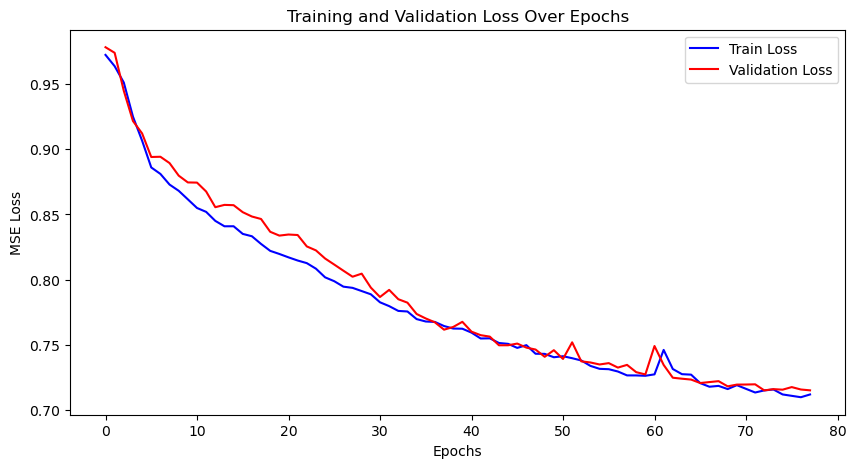

In [15]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if a GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Define the Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store losses for both training and validation
train_losses = []
val_losses = []

# Set the number of epochs
num_epochs = 1000  # Set a high value; early stopping will prevent overfitting

# Early Stopping Parameters
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float('inf')
counter = 0  # Counts epochs without improvement

# Checkpoint saving parameters
checkpoint_dir = 'checkpoints_02'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist
max_checkpoints = 5  # Number of checkpoints to keep

# Begin training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize training loss for this epoch

    # Training loop
    for batch_data in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Move data to the appropriate device (CPU or GPU)
        batch_data = batch_data.to(device).float()

        # Forward pass through the model
        outputs = model(batch_data)

        # Compute reconstruction loss (MSE between input and output)
        loss = criterion(outputs, batch_data)

        # Backward pass and optimization
        optimizer.zero_grad()  # Reset the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step to update weights

        # Accumulate loss for this batch
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validate the model at the end of each epoch
    model.eval()  # Set the model to evaluation mode
    val_loss = 0  # Initialize validation loss for this epoch

    # Validation loop (no gradient tracking)
    with torch.no_grad():
        for val_data in val_dataloader:
            # Move validation data to the appropriate device
            val_data = val_data.to(device).float()

            # Forward pass on the validation data
            val_outputs = model(val_data)

            # Compute reconstruction loss on validation set
            loss = criterion(val_outputs, val_data)

            # Accumulate validation loss for this batch
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Print losses for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # ---- Model Saving Strategies ---- #

    # 1. Save a full checkpoint after each epoch
    checkpoint = {
        'epoch': epoch + 1,  # Save the current epoch (0-indexed, so we add 1)
        'model_state_dict': model.state_dict(),  # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state
        'best_val_loss': best_val_loss,  # Keep track of best validation loss
    }
    torch.save(checkpoint, f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth")
    print(f"Full checkpoint saved for epoch {epoch+1}")

    # 2. Manage recent checkpoints (keep only the last `N` checkpoints and delete older ones)
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_")])
    if len(checkpoints) > max_checkpoints:
        os.remove(os.path.join(checkpoint_dir, checkpoints[0]))  # Remove the oldest checkpoint
        print(f"Removed old checkpoint: {checkpoints[0]}")

    # 3. Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pth")  # Save model state dict as best model
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation losses after all epochs are complete
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


Step 8: Analyze the Learned Representations
8.1: Extract Latent Features from the training data

In [16]:
latent_features = []

model.eval()  # Set to evaluation mode

# Extract latent features from training data only
with torch.no_grad():
    for batch_data in train_dataloader:
        batch_data = batch_data.to(device).float()
        
        # Encoder forward pass
        _, hidden = model.encoder_rnn(batch_data)
        
        # Squeeze the extra dimension if necessary
        hidden = hidden.squeeze(0)  # Now shape is (batch_size, hidden_size)
        
        # Convert to numpy and append to list
        latent_features.append(hidden.cpu().numpy())

# Concatenate all latent features
latent_features = np.vstack(latent_features)


8.2: Perform Clustering on Latent Features

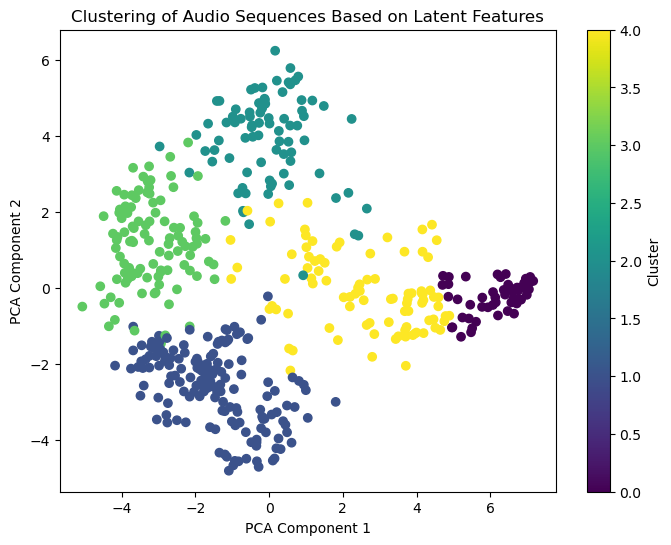

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform clustering
n_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(latent_features)

# Visualize using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.title('Clustering of Audio Sequences Based on Latent Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


Step 9: Optional - Listen to Samples from Each Cluster

In [18]:
import IPython.display as ipd

def play_samples_from_clusters(labels, audio_data, n_clusters=5, max_samples_per_cluster=1):
    # Dictionary to track how many samples have been played from each cluster
    samples_played = {cluster: 0 for cluster in range(n_clusters)}
    
    # Iterate over the raw audio data and labels directly
    for index, y in enumerate(audio_data):
        # Get the cluster label for this sample
        cluster_label = labels[index]
        
        # Check if we've played the max number of samples for this cluster
        if samples_played[cluster_label] < max_samples_per_cluster:
            print(f'Playing audio from Cluster {cluster_label}')
            
            # Play the audio sample
            ipd.display(ipd.Audio(y, rate=16000))
            
            # Increment the count for this cluster
            samples_played[cluster_label] += 1
        
        # Stop if all clusters have played their max number of samples
        if all(samples_played[cluster] >= max_samples_per_cluster for cluster in samples_played):
            break

# Example Usage:
# Assuming 'labels' contains the cluster assignments (e.g., from KMeans)
# and 'audio_data' is the list of raw audio arrays corresponding to the dataset

play_samples_from_clusters(labels, audio_data, n_clusters=5, max_samples_per_cluster=5)


Playing audio from Cluster 1


Playing audio from Cluster 4


Playing audio from Cluster 1


Playing audio from Cluster 3


Playing audio from Cluster 0


Playing audio from Cluster 2


Playing audio from Cluster 1


Playing audio from Cluster 3


Playing audio from Cluster 3


Playing audio from Cluster 0


Playing audio from Cluster 4


Playing audio from Cluster 1


Playing audio from Cluster 1


Playing audio from Cluster 3


Playing audio from Cluster 4


Playing audio from Cluster 4


Playing audio from Cluster 3


Playing audio from Cluster 4


Playing audio from Cluster 2


Playing audio from Cluster 2


Playing audio from Cluster 2


Playing audio from Cluster 0


Playing audio from Cluster 0


Playing audio from Cluster 0


Playing audio from Cluster 2


## Export to ONXX

In [19]:
# Assuming your earlier code for extracting features is still available:
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]
audio_data = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    audio_data.append(y)

# Extract MFCC features from all audio data
feature_sequences = []

for y in tqdm(audio_data, desc='Extracting features'):
    features = extract_mfcc_features(y)
    feature_sequences.append(features)


Extracting features: 100%|██████████| 615/615 [00:03<00:00, 165.34it/s]


In [20]:
import torch
import os

# Step 10.1: Define the Directory and File Paths
checkpoint_dir = 'checkpoints_02'  # Directory to save the ONNX model
os.makedirs(checkpoint_dir, exist_ok=True)

# Path to save the ONNX model
onnx_model_path = os.path.join(checkpoint_dir, 'rnn_autoencoder.onnx')

# Step 10.2: Load the Best Trained Model
# Make sure the model class (RNNAutoencoder) and model definition is available
input_size = feature_sequences[0].shape[1]  # Number of MFCC features
hidden_size = 120  # Define your hidden size

# Instantiate and load the trained model
model = RNNAutoencoder(input_size, hidden_size)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))
model.eval()

# Step 10.3: Define a Dummy Input (Batch Size, Sequence Length, Input Size)
dummy_input = torch.randn(1, 100, input_size)  # 1 sample, 100 time steps, input size as MFCC features

# Step 10.4: Export the Model to ONNX
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    input_names=['input'],
    output_names=['output'],
    opset_version=11
)

print(f"ONNX model saved to {onnx_model_path}")


ONNX model saved to checkpoints_02/rnn_autoencoder.onnx


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_94845/3933704565.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi